In [11]:
import numpy as np
import pandas as pd
import pickle
from glob import glob
import gzip
from tqdm.notebook import tqdm
from haversine import haversine

# Preprocess Data (Fwy 405 N)
Creates a simplified data set that will be good for model testing.  
Selects only stations on Fwy 405 N (the main freeway in LA)  
Creates an adjacency matrix for these stations only and a concatenated csv with 3 months of speed data   
Files are stored in `/data/processed/fwy-405-n/`

### Setup

In [2]:
# read station metadata
meta = pd.read_csv('../data/pems/d07_text_meta_2021_10_20.txt', sep='\t')
meta = meta[['ID', 'Fwy', 'Dir', 'District', 'County', 'City', 'State_PM', 'Abs_PM',
             'Latitude', 'Longitude', 'Length', 'Type', 'Lanes', 'Name']]

meta.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
0,715898,5,S,7,37,40032.0,.71,117.280,33.880183,-118.021787,0.43,ML,3,PHOEBE
1,715900,5,S,7,37,40032.0,1.06,117.630,33.882892,-118.026822,NaN,OR,1,VALLEY VIEW
2,715901,5,N,7,37,40032.0,1.11,117.743,33.883400,-118.027451,NaN,OR,1,VALLEY VIEW
3,715903,5,N,7,37,69154.0,1.56,118.193,33.886992,-118.034125,NaN,OR,1,ALONDRA
4,715904,5,S,7,37,69154.0,2.27,118.840,33.892489,-118.044573,NaN,OR,1,CARMENITA


In [3]:
# read station data helper function
data_dict = pd.read_csv('../data/pems/station_dict.csv', names=['Feature', 'Description', 'Unit']).iloc[1:].reset_index(drop=True)
colnames = data_dict['Feature'].values.tolist()
colnames_subset = ['Timestamp', 'Station', 'Station Length', 'Samples', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 
                'Lane N Samples', 'Lane N Flow', 'Lane N Avg Occ', 'Lane N Avg Speed', 'Lane N Observed']

FILES = glob('../data/pems/*.gz')

def read_station_data(file_no):

    with gzip.open(FILES[file_no]) as f:
        df = pd.read_csv(f, index_col=False, names=colnames)[colnames_subset]

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    return df

### Filter Data
Only use sensors along Fwy 405 N route  
Build adjacency matrix using absolute postmile

In [4]:
# select only Fwy 405 N mainlines
meta = meta[(meta['Fwy'] == 405) & (meta['Type'] == 'ML') & (meta['Dir'] == 'N')]
meta = meta.sort_values('Abs_PM')
meta = meta.reset_index(drop=True)
meta.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
0,771826,405,N,7,37,43000.0,.11,24.058,33.787054,-118.094505,0.303,ML,4,N. OF 605
1,717696,405,N,7,37,43000.0,.6,24.548,33.791829,-118.100867,0.495,ML,4,STUDEBAKER
2,718219,405,N,7,37,43000.0,1.1,25.048,33.796718,-118.107431,0.565,ML,4,PALO VERDE
3,717701,405,N,7,37,43000.0,1.73,25.678,33.802431,-118.115997,0.675,ML,4,WOODRUFF
4,717703,405,N,7,37,43000.0,2.45,26.398,33.802865,-118.128314,0.505,ML,4,BELLFLOWER 2


In [6]:
# write station metadata file
meta.to_csv('../data/processed/fwy-405-n/meta.csv', index=False)

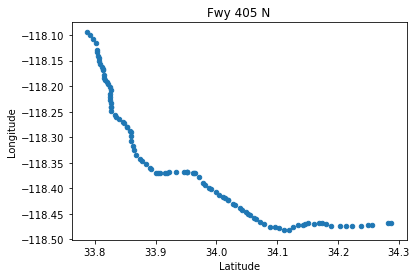

In [7]:
# show route
p = meta.plot.scatter('Latitude', 'Longitude', title='Fwy 405 N')

In [9]:
stations

array([771826, 717696, 718219, 717701, 717703, 718227, 717706, 717709,
       716632, 771845, 717711, 717713, 717715, 717717, 717719, 717720,
       717721, 771863, 717723, 771877, 717727, 771898, 717729, 771915,
       718251, 776739, 775936, 717733, 771939, 717735, 716659, 766505,
       718259, 773000, 716663, 717740, 717742, 717744, 716670, 718266,
       718267, 717750, 717752, 717755, 717758, 717760, 717763, 717765,
       716689, 717769, 761455, 716694, 759427, 769228, 761482, 776844,
       761492, 717776, 717777, 764583, 717779, 771969, 718291, 769496,
       718292, 768643, 717787, 717790, 772437, 716714, 772455, 718500,
       768969, 717794, 716720, 717797, 775155, 717798, 775261, 717799,
       717800, 717801, 775137, 717804, 775183, 716733, 775120, 717806,
       716738, 716739, 775225, 717814, 777065, 767812, 717818, 767351,
       717819, 717823, 767367, 717825, 717827, 771808, 771767, 772011,
       772024])

In [15]:
haversine((99, 98), (101, 102))

235.2898002152186

In [20]:
# build adj matrix
stations = np.array(meta['ID'])

# build station-ind mapper
station_ind_mapper = {station: i for i, station in enumerate(stations)}

# distance connecting all stations
mat_v1 = np.array( [[haversine((float(row1['Latitude']), float(row1['Longitude'])), (float(row2['Latitude']), float(row2['Longitude']))) for i1, row1 in meta.iterrows()] for i2, row2 in meta.iterrows()] )

# distance connecting only upstream stations; uses manhattan as distance metric
mat_v2 = np.array( [[y-x if y-x>=0 else np.inf for y in meta['Abs_PM']] for x in meta['Abs_PM']] )

# distance connecting only adjacent stations; uses manhattan as distance metric
mat_v3 = np.array( [[abs(x-y) if abs(i-j)<=1 else np.inf for (i,y) in enumerate(meta['Abs_PM'])] \
                                                         for (j,x) in enumerate(meta['Abs_PM'])] )
mat_v1

array([[ 0.        ,  0.79219735,  1.60672239, ..., 62.73669169,
        64.93084452, 65.40730117],
       [ 0.79219735,  0.        ,  0.81452781, ..., 61.96946942,
        64.16940767, 64.64736247],
       [ 1.60672239,  0.81452781,  0.        , ..., 61.18205913,
        63.38815041, 63.8676968 ],
       ...,
       [62.73669169, 61.96946942, 61.18205913, ...,  0.        ,
         2.81791876,  3.46434814],
       [64.93084452, 64.16940767, 63.38815041, ...,  2.81791876,
         0.        ,  0.64828939],
       [65.40730117, 64.64736247, 63.8676968 , ...,  3.46434814,
         0.64828939,  0.        ]])

### Extract Station Data
Get a single dataframe with time and speed for the selected sensors

In [22]:
function to extract time x speed dataframe for selected stations
def get_station_data(start_day, end_day):
    data = []
    for i in tqdm( range(start_day, end_day) ):
        df = read_station_data(i)
        df = df[df['Station'].isin(meta['ID'])]
        df = df[['Timestamp', 'Station', 'Avg Speed']]
        df.columns = ['Time', 'Station', 'Speed']
        data.append(df)
    
    return pd.concat(data).reset_index(drop=True)

# select May - July
df = get_station_data(120, 212)
df

,Time,Station,Speed
0,2021-02-04 00:00:00,716632,71.7
1,2021-02-04 00:00:00,716659,71.9
2,2021-02-04 00:00:00,716663,70.5
3,2021-02-04 00:00:00,716670,68.0
4,2021-02-04 00:00:00,716689,65.2
...,...,...,...
2785006,2021-01-20 23:55:00,775261,69.6
2785007,2021-01-20 23:55:00,775936,64.5
2785008,2021-01-20 23:55:00,776739,68.5
2785009,2021-01-20 23:55:00,776844,66.5


In [26]:
pivoted_df = df.pivot_table(values='Speed', index='Time', columns='Station')
pivoted_df.index.name = None
pivoted_df.columns.name = None
pivoted_df.index = pd.to_datetime(pivoted_df.index)
pivoted_df.head()

,716632,716659,716663,716670,716689,716694,716714,716720,716733,716738,...,775120,775137,775155,775183,775225,775261,775936,776739,776844,777065
2021-01-01 00:00:00,71.4,68.6,68.5,67.9,65.3,68.5,71.2,66.0,69.9,71.7,...,71.5,71.0,69.1,68.5,66.6,70.9,64.1,69.1,67.8,68.5
2021-01-01 00:05:00,71.5,68.2,70.2,68.3,64.9,67.6,71.2,65.1,69.6,70.3,...,70.9,70.1,69.1,67.7,64.5,70.4,64.8,68.9,68.3,68.6
2021-01-01 00:10:00,71.6,68.4,70.2,67.6,65.2,68.1,70.2,65.8,69.3,70.1,...,71.2,71.0,68.3,67.3,67.5,70.2,64.2,69.0,68.1,69.1
2021-01-01 00:15:00,71.6,68.6,70.2,66.9,64.6,69.5,69.3,65.7,70.1,71.0,...,71.1,71.8,67.4,68.9,63.8,70.1,63.9,68.7,67.8,68.7
2021-01-01 00:20:00,71.9,67.0,66.6,67.0,64.5,68.4,69.8,66.1,70.5,70.7,...,72.0,70.8,68.6,68.4,63.5,70.0,64.1,68.6,67.0,69.0


**Save**

In [28]:
## save adj_mat 
with open('../data/processed/fwy_405_n_ds/adj_mat.dat', 'wb')  as f:
    pickle.dump(mat_v1, f)

## save mapper for adj_mat index to station ID
with open('../data/processed/fwy_405_n_ds/adj_mat_ind_station_mapper.dat', 'wb') as f:
    pickle.dump({station_ind_mapper[station]: station for station in station_ind_mapper}, f)

## save full speed df concatenated for all days in 2021
with open('../data/processed/fwy_405_n_ds/speeds.dat', 'wb')  as f:
    pickle.dump(pivoted_df, f)